<a href="https://colab.research.google.com/github/grmanjar-cmyk/MLB_hitting_skills_ML_Model/blob/main/hitting_skill_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Baseball Hitter Performance Using Component Skills

### Project Goal
This project aims to build and evaluate a machine learning model that predicts a baseball player's future offensive performance, measured by `xwOBA` (Expected Weighted On-Base Average).

The central hypothesis is that a model built on a curated set of underlying hitting "component skills" (like bat speed, plate discipline, and bat control) can be as predictive as more comprehensive statcast stats that take into account batted ball outcomes like launch angle and exit velocity.  

---

### Process Overview

The notebook follows a standard data science workflow:
1.  **Data Loading & Inspection:** The dataset, sourced from Baseball Savant, contains aggregated player-season data from 2023 to 2025.
2.  **Feature Selection & Engineering:** After analyzing the available metrics, a final set of 7 features was selected to represent four key component skills. A new `discipline_ratio` feature was engineered to better capture plate discipline.
3.  **Model Training:** A Random Forest Regressor was trained on data from the 2023 and 2024 seasons.
4.  **Model Evaluation:** The model's ability to predict future performance was tested on unseen data from the 2025 season.
5.  **Baseline Comparison:** The final model's performance was benchmarked against simpler, single-feature models to validate its effectiveness.

---

### Key Findings

The final Random Forest model successfully predicted 2025 `xwOBA` with a **Root Mean Squared Error (RMSE) of 0.0199**.

This result proved the initial hypothesis, as the model was approximately **7% more accurate** than the best-performing single-feature baseline model (which used `barrel_batted_rate`).

In [6]:
from google.colab import files
upload = files.upload()

Saving 2023_to_2025_hitting_data_skills.csv to 2023_to_2025_hitting_data_skills (1).csv


In [7]:
import pandas as pd
df_hitting=pd.read_csv('2023_to_2025_hitting_data_skills.csv')

print (df_hitting.columns)

df_hitting.head()

Index(['last_name, first_name', 'player_id', 'year', 'slg_percent',
       'on_base_percent', 'on_base_plus_slg', 'isolated_power', 'xslg', 'woba',
       'xwoba', 'avg_swing_speed', 'fast_swing_rate', 'blasts_contact',
       'blasts_swing', 'squared_up_contact', 'squared_up_swing',
       'attack_angle', 'attack_direction', 'ideal_angle_rate',
       'vertical_swing_path', 'exit_velocity_avg', 'sweet_spot_percent',
       'barrel_batted_rate', 'solidcontact_percent', 'avg_best_speed',
       'z_swing_percent', 'oz_swing_percent', 'oz_swing_miss_percent',
       'oz_contact_percent', 'meatball_swing_percent', 'meatball_percent',
       'iz_contact_percent', 'whiff_percent', 'swing_percent', 'pull_percent',
       'straightaway_percent', 'opposite_percent', 'groundballs_percent',
       'flyballs_percent', 'linedrives_percent', 'popups_percent'],
      dtype='object')


,"last_name, first_name",player_id,year,slg_percent,on_base_percent,on_base_plus_slg,isolated_power,xslg,woba,xwoba,...,iz_contact_percent,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent
0,"Davis, J.D.",605204,2023,0.412,0.325,0.737,0.164,0.411,0.321,0.323,...,73.2,34.0,53.1,38.9,33.5,27.5,53.3,20.4,23.1,3.3
1,"Ozuna, Marcell",542303,2023,0.558,0.346,0.904,0.284,0.577,0.381,0.393,...,82.9,26.7,48.4,42.5,30.9,26.6,39.9,32.4,21.9,5.8
2,"Torkelson, Spencer",679529,2023,0.446,0.313,0.759,0.213,0.484,0.326,0.349,...,82.4,24.7,46.2,46.1,30.7,23.2,33.9,31.6,24.5,10.0
3,"Betts, Mookie",605141,2023,0.579,0.408,0.987,0.272,0.563,0.416,0.407,...,91.8,16.7,38.1,45.4,35.3,19.3,27.6,35.7,29.3,7.5
4,"McMahon, Ryan",641857,2023,0.431,0.322,0.753,0.191,0.445,0.325,0.335,...,73.6,32.3,47.4,33.9,38.6,27.5,44.2,28.1,26.1,1.7


In [8]:
df_hitting.describe()

,player_id,year,slg_percent,on_base_percent,on_base_plus_slg,isolated_power,xslg,woba,xwoba,avg_swing_speed,...,iz_contact_percent,whiff_percent,swing_percent,pull_percent,straightaway_percent,opposite_percent,groundballs_percent,flyballs_percent,linedrives_percent,popups_percent
count,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,...,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000,407.000000
mean,643198.302211,2024.024570,0.439064,0.331233,0.770297,0.179592,0.435034,0.332553,0.333563,71.941769,...,83.686241,23.965111,47.537346,38.721376,36.580835,24.696560,41.921622,27.066339,24.218182,6.797543
std,51428.882192,0.827118,0.060698,0.029722,0.082374,0.051461,0.064413,0.031123,0.032180,2.722444,...,4.893759,5.943222,4.842101,6.017103,3.476420,4.123839,5.989858,4.968226,2.473388,2.555405
min,457705.000000,2023.000000,0.296000,0.267000,0.582000,0.051000,0.300000,0.260000,0.261000,62.600000,...,71.400000,5.300000,35.500000,23.900000,25.800000,14.100000,25.800000,10.700000,17.600000,1.000000
25%,608613.000000,2023.000000,0.398500,0.313000,0.717000,0.146500,0.392500,0.313000,0.314000,70.450000,...,80.500000,20.150000,44.300000,34.750000,34.100000,21.900000,37.650000,23.500000,22.400000,4.900000
50%,663728.000000,2024.000000,0.435000,0.327000,0.762000,0.176000,0.428000,0.330000,0.329000,72.000000,...,83.800000,24.200000,47.400000,38.700000,36.700000,24.600000,42.100000,27.000000,24.300000,6.500000
75%,672667.500000,2025.000000,0.473000,0.348500,0.813500,0.208500,0.466000,0.349000,0.349000,73.750000,...,87.000000,28.500000,50.500000,42.900000,39.100000,27.400000,46.000000,30.300000,25.900000,8.500000
max,808982.000000,2025.000000,0.701000,0.458000,1.159000,0.379000,0.722000,0.476000,0.479000,78.800000,...,96.100000,38.200000,62.300000,54.700000,47.400000,40.500000,61.400000,41.800000,31.300000,18.200000


In [9]:
# Define the name of our single target variable
target_variable_name = 'xwoba'

# Define list of features based on assumed component skills of hitting and the stats that most directly measure them, in combination where necessary
feature_names = [
    # Skill 1: Swing Speed
    'avg_swing_speed',
    'fast_swing_rate',

    # Skill 2: Swing Decisions (to be engineered)
    'z_swing_percent',
    'oz_swing_percent',

    # Skill 3: On Time / Directional Power
    'ideal_angle_rate',
    'pull_percent',

    # Skill 4: Bat Head Control / Contact Quality (Final Version)
    'squared_up_contact',
    'sweet_spot_percent'] # Using sweet_spot_percent to isolate skill from power which barrel rate would include presumably

In [10]:
# Create our features DataFrame (X) and target Series (y)
X = df_hitting[feature_names]
y = df_hitting[target_variable_name]

# --- Verification ---
print("Our FINAL Features DataFrame (X):")
print(X.head())
print("\n" + "="*30 + "\n")
print("Our Target Series (y):")
print(y.head())

Our FINAL Features DataFrame (X):
   avg_swing_speed  fast_swing_rate  z_swing_percent  oz_swing_percent  \
0             72.2             18.7             79.1              26.5   
1             75.0             53.1             69.8              29.7   
2             75.0             50.3             67.5              23.6   
3             71.3             20.7             60.3              16.6   
4             72.2             23.1             67.6              25.4   

   ideal_angle_rate  pull_percent  squared_up_contact  sweet_spot_percent  
0              41.5          38.9                33.2                33.5  
1              51.6          42.5                35.2                34.9  
2              55.5          46.1                29.8                33.2  
3              56.3          45.4                42.4                42.5  
4              39.7          33.9                26.2                39.4  


Our Target Series (y):
0    0.323
1    0.393
2    0.349
3    0.

In [11]:
# --- Step 2 (Part B): Feature Engineering ---

# Create the new 'discipline_ratio' column
# We add a small number (0.01) to the denominator to prevent division by zero errors
# for any players who might have a 0% oz_swing_percent.
X['discipline_ratio'] = X['z_swing_percent'] / (X['oz_swing_percent'] + 0.001)

# Now, we remove the original columns because their information is now captured
# in our new, more powerful feature. This also prevents multicollinearity.
X = X.drop(columns=['z_swing_percent', 'oz_swing_percent'])

# --- Verification ---
print("Our DataFrame (X) with the new 'discipline_ratio' feature:")
print(X.head())

print("\nVerifying the columns have been updated:")
print(X.columns)

Our DataFrame (X) with the new 'discipline_ratio' feature:
   avg_swing_speed  fast_swing_rate  ideal_angle_rate  pull_percent  \
0             72.2             18.7              41.5          38.9   
1             75.0             53.1              51.6          42.5   
2             75.0             50.3              55.5          46.1   
3             71.3             20.7              56.3          45.4   
4             72.2             23.1              39.7          33.9   

   squared_up_contact  sweet_spot_percent  discipline_ratio  
0                33.2                33.5          2.984793  
1                35.2                34.9          2.350089  
2                29.8                33.2          2.860048  
3                42.4                42.5          3.632311  
4                26.2                39.4          2.661313  

Verifying the columns have been updated:
Index(['avg_swing_speed', 'fast_swing_rate', 'ideal_angle_rate',
       'pull_percent', 'squared_up_

/tmp/ipython-input-3178983220.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['discipline_ratio'] = X['z_swing_percent'] / (X['oz_swing_percent'] + 0.001)


In [12]:
# --- Step 3: Splitting the Data for Training and Validation ---

# First, create boolean "masks" to identify which rows belong to which year set.
# A mask is a Series of True/False values.
is_training_year = df_hitting['year'] < 2025  # True for years 2023, 2024
is_validation_year = df_hitting['year'] == 2025 # True for year 2025

# Use these masks to select the correct rows from our X and y DataFrames.
X_train = X[is_training_year]
y_train = y[is_training_year]

X_val = X[is_validation_year]
y_val = y[is_validation_year]

# --- Verification ---
# It's crucial to check the size (shape) of our new DataFrames.
print("Shape of our Training Features (X_train):", X_train.shape)
print("Shape of our Training Target (y_train):  ", y_train.shape)
print("-" * 40)
print("Shape of our Validation Features (X_val):", X_val.shape)
print("Shape of our Validation Target (y_val):  ", y_val.shape)

print("\nSplit successful! We have training data to learn from and validation data to test on.")

Shape of our Training Features (X_train): (263, 7)
Shape of our Training Target (y_train):   (263,)
----------------------------------------
Shape of our Validation Features (X_val): (144, 7)
Shape of our Validation Target (y_val):   (144,)

Split successful! We have training data to learn from and validation data to test on.


Correlation of each feature with 'xwoba':
xwoba                 1.000000
fast_swing_rate       0.543630
avg_swing_speed       0.492488
discipline_ratio      0.376473
sweet_spot_percent    0.284452
squared_up_contact    0.067502
pull_percent          0.047605
ideal_angle_rate      0.013723
Name: xwoba, dtype: float64


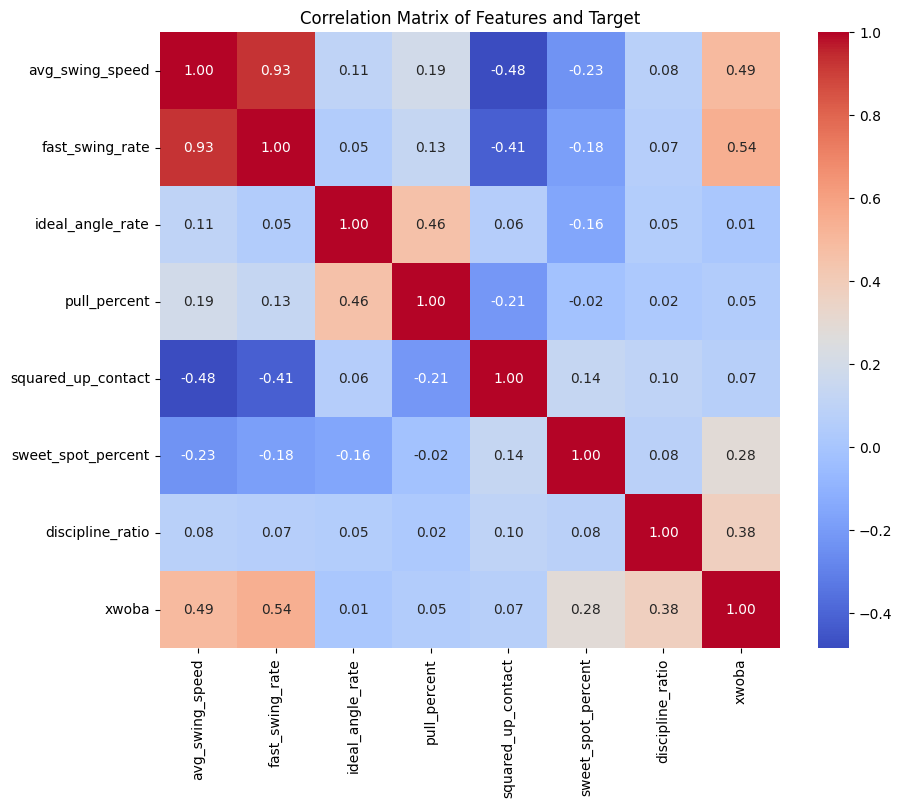

In [13]:
# --- Step 4: Look for Correlations ---

import seaborn as sns
import matplotlib.pyplot as plt

# For this analysis, it's easier to temporarily combine our training data back together
train_df = pd.concat([X_train, y_train], axis=1)

# Calculate the correlation matrix
corr_matrix = train_df.corr()

# Let's first look at the correlations with our target variable, sorted from highest to lowest
target_corr = corr_matrix[target_variable_name].sort_values(ascending=False)

print(f"Correlation of each feature with '{target_variable_name}':")
print(target_corr)

# Now, let's create a heatmap for a nice visual representation of the whole matrix
plt.figure(figsize=(10, 8)) # Adjust the size of the plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features and Target")
plt.show()

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np


In [15]:
# 1. Initialize the Model
# We set a random_state so that the results are reproducible each time we run the code.
# n_estimators is the number of "trees" in the forest. 100 is a good default.
# max_depth limits how complex each tree can be, which helps prevent overfitting.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5)

In [16]:
# 2. Train the Model
# The .fit() method is where the model 'learns' the patterns from our training data.
print("Training the Random Forest model on 2023-2024 data...")
rf_model.fit(X_train, y_train)
print("Training complete.")

Training the Random Forest model on 2023-2024 data...
Training complete.


In [17]:
# 3. Make Predictions on the Unseen Validation Set
# The .predict() method uses the trained model to forecast the 2025 xwoba.
print("Making predictions on the 2025 validation data...")
predictions = rf_model.predict(X_val)

Making predictions on the 2025 validation data...


In [18]:
# 4. Evaluate the Model's Performance
# We'll use Root Mean Squared Error (RMSE). Lower is better.
# It tells us, on average, how many wOBA points our prediction was off by.
rmse = np.sqrt(mean_squared_error(y_val, predictions))

print("\n--- Model Evaluation ---")
print(f"Validation Set Root Mean Squared Error (RMSE): {rmse:.4f}")


--- Model Evaluation ---
Validation Set Root Mean Squared Error (RMSE): 0.0199


In [19]:
comparison_df = pd.DataFrame({'Actual_xwOBA': y_val.round(3),
                              'Predicted_xwOBA': predictions.round(3)})
print("\n--- Sample of Predictions vs. Actual Values ---")
print(comparison_df.head(10))


--- Sample of Predictions vs. Actual Values ---
     Actual_xwOBA  Predicted_xwOBA
263         0.352            0.340
264         0.403            0.392
265         0.320            0.311
266         0.314            0.342
267         0.385            0.373
268         0.321            0.326
269         0.332            0.313
270         0.459            0.423
271         0.372            0.334
272         0.358            0.336


In [20]:

comparison_df['Error'] = (comparison_df['Predicted_xwOBA'] - comparison_df['Actual_xwOBA']).abs()
worst_predictions = comparison_df.sort_values(by='Error', ascending=False).head(10)

# 1. Get the identifying columns from our original DataFrame
player_info = df_hitting[['last_name, first_name', 'year']]

# 2. Join the error info, features, and player info together
# Start with the worst predictions (Actual, Predicted, Error)
analysis_table = worst_predictions.join(player_info)

# Now join the feature data (the X_val values for these players)
analysis_table = analysis_table.join(X_val.loc[worst_predictions.index])

# 3. Reorder the columns for much better readability
# We want the identifiers and results first, followed by the features the model saw.
feature_names_in_model = X_train.columns.tolist() # Get the final list of feature names
column_order = [
    'last_name, first_name', 'year',
    'Actual_xwOBA', 'Predicted_xwOBA', 'Error'
]

final_analysis_table = analysis_table[column_order]


print("--- Top 10 Player-Seasons the Model Missed---")
# Set pandas display options to see all columns
pd.set_option('display.max_columns', None)
print(final_analysis_table)

--- Top 10 Player-Seasons the Model Missed---
    last_name, first_name  year  Actual_xwOBA  Predicted_xwOBA  Error
372      Springer, George  2025         0.405            0.359  0.046
295            Soto, Juan  2025         0.429            0.383  0.046
356        Busch, Michael  2025         0.379            0.333  0.046
292        Grisham, Trent  2025         0.366            0.322  0.044
354      Chourio, Jackson  2025         0.305            0.349  0.044
331        Volpe, Anthony  2025         0.299            0.342  0.043
290          Beck, Jordan  2025         0.300            0.341  0.041
304        Devers, Rafael  2025         0.367            0.326  0.041
361           Cruz, Oneil  2025         0.322            0.363  0.041
337      Butler, Lawrence  2025         0.303            0.343  0.040


In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# --- Baseline Model Comparison ---

# The performance of our current Random Forest model
our_model_rmse = 0.0199

# List of the single, powerful features we want to test
baseline_features = [
    'barrel_batted_rate',
    'exit_velocity_avg',
    'blasts_swing'
]

print("--- Testing Baseline Models vs. Our Model ---")

# Loop through each feature and build a simple model for it
for feature in baseline_features:

    # 1. Prepare the data for this specific feature
    # We need to get the feature data from the original df_hitting DataFrame
    # Note the double brackets [['...']] to keep it as a DataFrame
    X_train_single = df_hitting[df_hitting['year'] < 2025][[feature]]
    X_val_single = df_hitting[df_hitting['year'] == 2025][[feature]]

    # The y_train and y_val (our target) are the same as before

    # 2. Build and train a simple Linear Regression model
    linear_model = LinearRegression()
    linear_model.fit(X_train_single, y_train)

    # 3. Make and evaluate predictions
    predictions_single = linear_model.predict(X_val_single)
    rmse_single = np.sqrt(mean_squared_error(y_val, predictions_single))

    print(f"Simple Model using ONLY '{feature}':\t RMSE = {rmse_single:.4f}")

print("-" * 50)
print(f"Our Multi-Feature Random Forest Model:\t RMSE = {our_model_rmse:.4f}")
print("-" * 50)

--- Testing Baseline Models vs. Our Model ---
Simple Model using ONLY 'barrel_batted_rate':	 RMSE = 0.0213
Simple Model using ONLY 'exit_velocity_avg':	 RMSE = 0.0231
Simple Model using ONLY 'blasts_swing':	 RMSE = 0.0241
--------------------------------------------------
Our Multi-Feature Random Forest Model:	 RMSE = 0.0199
--------------------------------------------------


In [22]:
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score

# --- Assume 'y_val' and 'predictions' are already defined in your script ---
# y_val: The true xwOBA values for your validation data
# predictions: The xwOBA values predicted by your random forest model

# Calculate R-squared (Coefficient of Determination)
r_squared = r2_score(y_val, predictions)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_val, predictions)

# Calculate Explained Variance Score
explained_variance = explained_variance_score(y_val, predictions)


# Print the results along with your original RMSE for a complete picture
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Explained Variance Score: {explained_variance:.4f}")

Root Mean Squared Error (RMSE): 0.0199
Mean Absolute Error (MAE): 0.0157
R-squared: 0.5612
Explained Variance Score: 0.5678


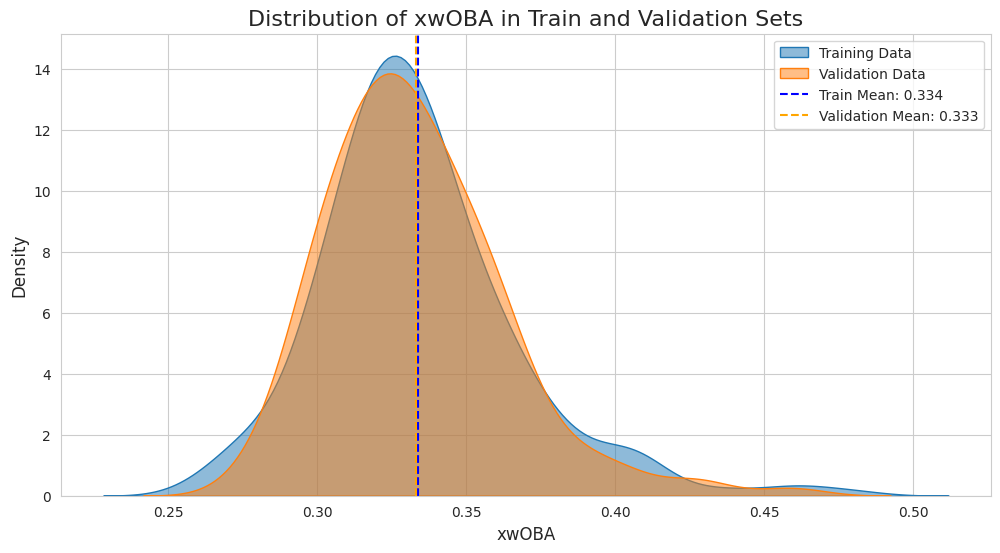

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a style for the plots
sns.set_style("whitegrid")

# Create a figure to hold the plots
plt.figure(figsize=(12, 6))

# Plot the distributions using a Kernel Density Estimate (KDE) plot
# A KDE plot is like a smoothed histogram and is great for comparing distributions
sns.kdeplot(y_train, label='Training Data', fill=True, alpha=0.5)
sns.kdeplot(y_val, label='Validation Data', fill=True, alpha=0.5)

# Add a vertical line for the mean of the training data to see the center
plt.axvline(y_train.mean(), color='blue', linestyle='--', label=f'Train Mean: {y_train.mean():.3f}')
# Add a vertical line for the mean of the validation data
plt.axvline(y_val.mean(), color='orange', linestyle='--', label=f'Validation Mean: {y_val.mean():.3f}')


# Add titles and labels for clarity
plt.title('Distribution of xwOBA in Train and Validation Sets', fontsize=16)
plt.xlabel('xwOBA', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.legend()

# Display the plot
plt.show()

/tmp/ipython-input-315893010.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


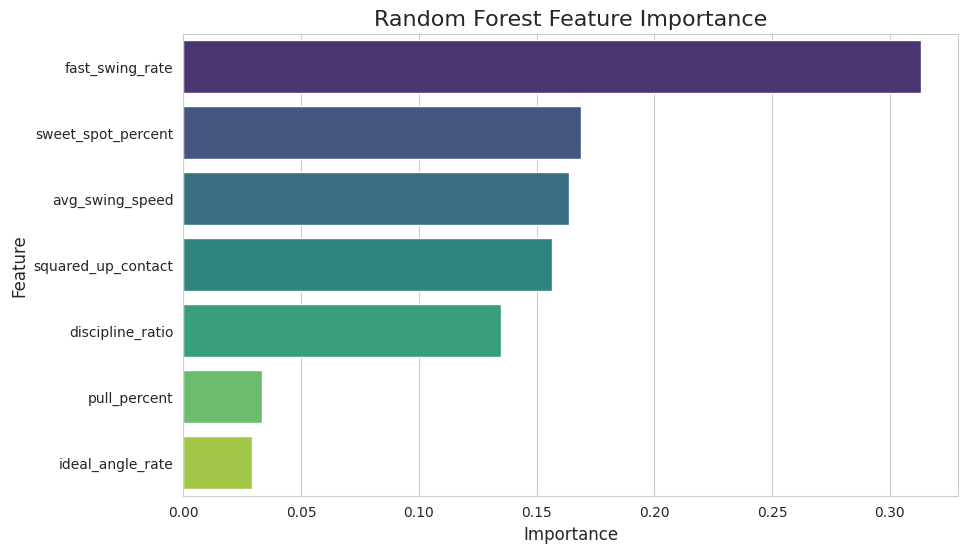

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier plotting
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')

# Add titles and labels
plt.title('Random Forest Feature Importance', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)

# Display the plot
plt.show()

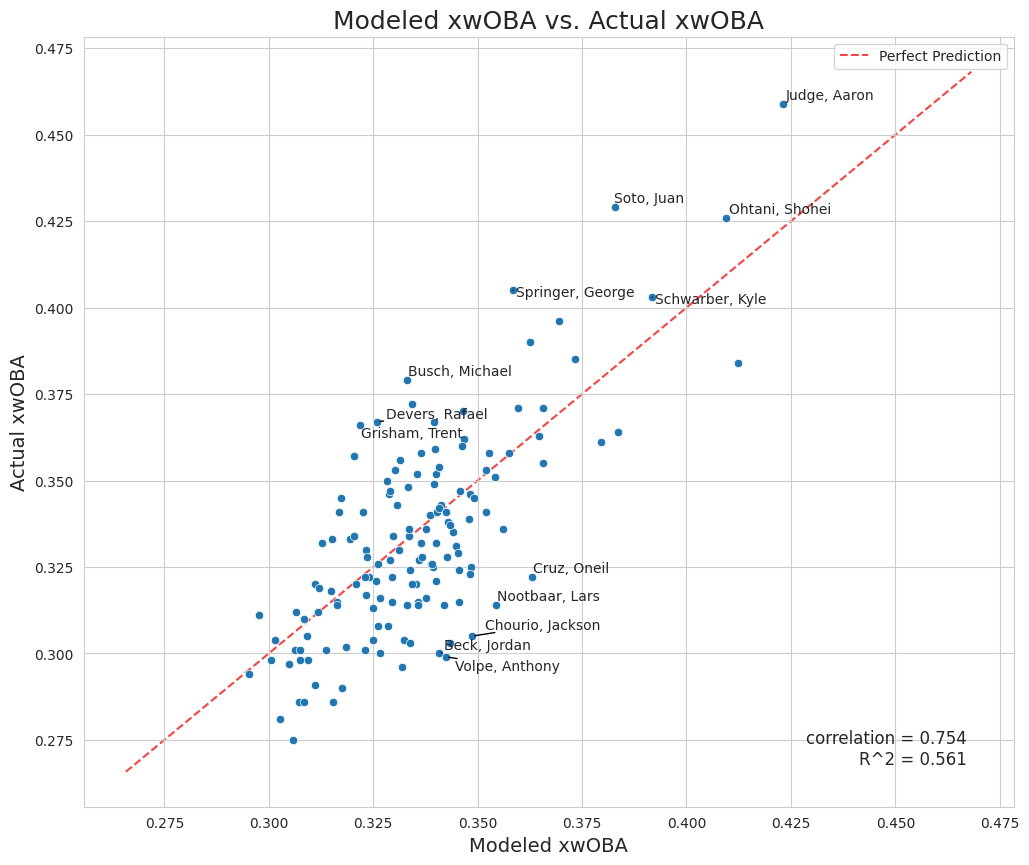

In [31]:
!pip install adjustText
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from adjustText import adjust_text # <-- Import the new library

# --- Step 1 & 2: Prepare DataFrames (No change here) ---
val_df = df_hitting.loc[y_val.index]
player_names = val_df['last_name, first_name']

plot_df = pd.DataFrame({
    'player_name': player_names,
    'predicted_xwoba': predictions,
    'actual_xwoba': y_val.values
})
plot_df['residual'] = plot_df['actual_xwoba'] - plot_df['predicted_xwoba']


# --- Step 3: Create the Scatter Plot (No change here) ---
plt.figure(figsize=(12, 10))
sns.scatterplot(x='predicted_xwoba', y='actual_xwoba', data=plot_df)

lims = [
    np.min([plt.gca().get_xlim(), plt.gca().get_ylim()]),
    np.max([plt.gca().get_xlim(), plt.gca().get_ylim()]),
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0, label='Perfect Prediction')


# --- Step 4: Add Player Labels (This is the updated section) ---
top_performers = plot_df.nlargest(5, 'actual_xwoba')
under_predicted = plot_df.nlargest(5, 'residual')
over_predicted = plot_df.nsmallest(5, 'residual')

players_to_label = pd.concat([top_performers, under_predicted, over_predicted]).drop_duplicates()

# Create a list to hold the text objects
texts = []
for i, player in players_to_label.iterrows():
    texts.append(plt.text(player['predicted_xwoba'],
                          player['actual_xwoba'],
                          player['player_name']))

# Call adjust_text to automatically move the labels
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black'))


# --- Step 5 & 6: Annotations and Final Touches (No change here) ---
correlation = plot_df['predicted_xwoba'].corr(plot_df['actual_xwoba'])
r_squared = r2_score(plot_df['actual_xwoba'], plot_df['predicted_xwoba'])

plt.text(0.95, 0.05, f'correlation = {correlation:.3f}\nR^2 = {r_squared:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='bottom', horizontalalignment='right')

plt.title('Modeled xwOBA vs. Actual xwOBA', fontsize=18)
plt.xlabel('Modeled xwOBA', fontsize=14)
plt.ylabel('Actual xwOBA', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()










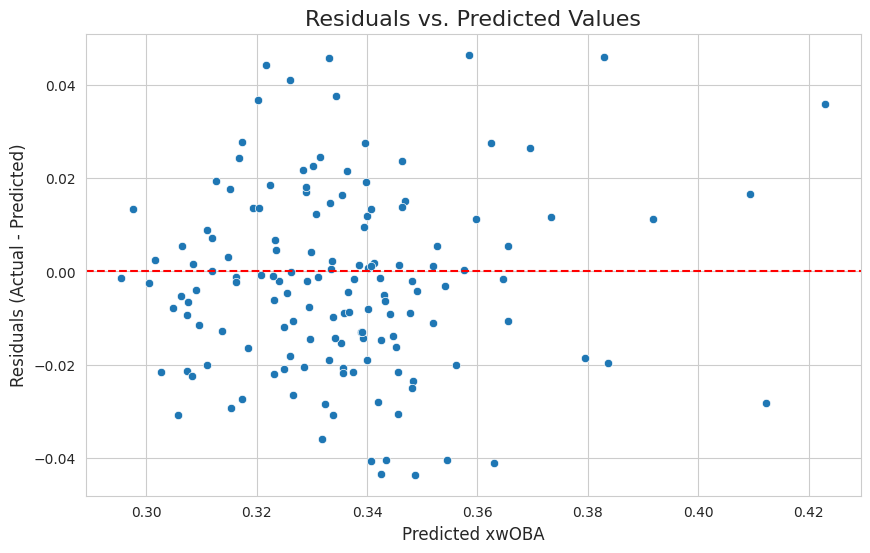

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- This assumes you have your predictions and true values for the validation set ---
# predictions: The model's predicted xwOBA values
# y_val: The true xwOBA values

# Calculate the residuals (the errors)
residuals = y_val - predictions

# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions, y=residuals)

# Add a horizontal line at y=0 (where the errors are zero)
plt.axhline(y=0, color='r', linestyle='--')

# Add titles and labels
plt.title('Residuals vs. Predicted Values', fontsize=16)
plt.xlabel('Predicted xwOBA', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)

# Display the plot
plt.show()